In [1]:
import pandas as pd
import sklearn as sk
import sqlite3
import numpy as np

In [2]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
wildfires = pd.read_sql_query("SELECT * from Fires", con)
fires = wildfires[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]

In [4]:
fires = fires.dropna()

In [5]:
sizes_we_want = ['C','D','E','F','G']
wildfires = fires[fires.FIRE_SIZE_CLASS.isin(sizes_we_want)]

In [6]:
wildfires = wildfires[wildfires['FIRE_SIZE_CLASS'] != 'C']

In [7]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [8]:
wildfires["NEW_DISC_DATE"] = compose_date(wildfires['FIRE_YEAR'], days=wildfires['DISCOVERY_DOY'])
wildfires.loc[wildfires['CONT_DOY'] < wildfires['DISCOVERY_DOY'], 'different_years'] = 1
wildfires.loc[wildfires['CONT_DOY'] >= wildfires['DISCOVERY_DOY'], 'different_years'] = 0
wildfires["NEW_CONT_DATE"] = compose_date(wildfires['FIRE_YEAR'] + wildfires['different_years'], days = wildfires["CONT_DOY"])
wildfires["CONT_TIME"] = (wildfires["NEW_CONT_DATE"] - wildfires["NEW_DISC_DATE"]).dt.days

In [9]:
wildfires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
16,17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA,2004-10-06,0.0,2004-10-21,15
17,18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA,2004-10-13,0.0,2004-10-17,4
39,40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC,2005-02-12,0.0,2005-02-13,1
116,119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD,2005-07-16,0.0,2005-07-17,1
117,120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD,2005-07-16,0.0,2005-07-16,0


In [10]:
wildfires = wildfires.drop(["different_years"], axis = 1)

In [11]:
wildfires = wildfires.set_index("FOD_ID")

In [12]:
wildfires = wildfires.drop(["NEW_DISC_DATE", "NEW_CONT_DATE"], axis = 1)

In [13]:
wildfires

,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,CONT_TIME
FOD_ID,,,,,,,,,,,,
17,USCAENF,2004,280,2.0,295.0,16823.0,G,38.523333,-120.211667,5.0,CA,15
18,USCAENF,2004,287,2.0,291.0,7700.0,G,38.780000,-120.260000,5.0,CA,4
40,USNCNCF,2005,43,5.0,44.0,125.0,D,36.001667,-81.590000,14.0,NC,1
119,USNENBF,2005,197,1.0,198.0,119.0,D,43.899167,-102.954722,5.0,SD,1
120,USNENBF,2005,197,1.0,197.0,119.0,D,43.892778,-102.948056,5.0,SD,0
...,...,...,...,...,...,...,...,...,...,...,...,...
300344916,USCABTU,2013,228,2.0,240.0,2264.0,F,39.443241,-121.433033,13.0,CA,12
300345098,USCASCU,2013,232,9.0,232.0,157.0,D,37.724917,-121.881111,13.0,CA,0
300345398,USCAHUU,2009,15,13.0,16.0,100.0,D,40.463517,-124.386817,13.0,CA,1


In [14]:
wildfires = wildfires.drop(["FIRE_SIZE", "CONT_DOY"], axis = 1)

In [15]:
wildfires['FIRE_SIZE_CLASS'] = pd.factorize(wildfires['FIRE_SIZE_CLASS'])[0]

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
stat_codes = wildfires.STAT_CAUSE_CODE.unique()
owner_codes = wildfires.OWNER_CODE.unique()

In [18]:
cause_mapping = {}
owner_mapping = {}
new_values = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [19]:
for i in range(len(stat_codes)):
    cause_mapping[stat_codes[i]] = new_values[i]
for i in range(len(owner_codes)):
    owner_mapping[owner_codes[i]] = new_values[i]

In [20]:
wildfires = wildfires.replace({"STAT_CAUSE_CODE":cause_mapping, "OWNER_CODE":owner_mapping})

In [21]:
wildfires = pd.concat([wildfires,pd.get_dummies(wildfires['STAT_CAUSE_CODE'], prefix='CAUSE')],axis=1)
wildfires = wildfires.drop(["STAT_CAUSE_CODE"], axis = 1)
wildfires = wildfires.drop(["OWNER_CODE"], axis = 1)
wildfires = pd.concat([wildfires,pd.get_dummies(wildfires['STATE'], prefix='STATE')],axis=1)
wildfires = wildfires.drop(["STATE"], axis = 1)

In [22]:
wildfires

,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,CONT_TIME,CAUSE_A,CAUSE_B,CAUSE_C,...,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
FOD_ID,,,,,,,,,,,,,,,,,,,,,
17,USCAENF,2004,280,0,38.523333,-120.211667,15,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18,USCAENF,2004,287,0,38.780000,-120.260000,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
40,USNCNCF,2005,43,1,36.001667,-81.590000,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
119,USNENBF,2005,197,1,43.899167,-102.954722,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
120,USNENBF,2005,197,1,43.892778,-102.948056,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300344916,USCABTU,2013,228,2,39.443241,-121.433033,12,1,0,0,...,0,0,0,0,0,0,0,0,0,0
300345098,USCASCU,2013,232,1,37.724917,-121.881111,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300345398,USCAHUU,2009,15,1,40.463517,-124.386817,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
features = wildfires.drop(["FIRE_SIZE_CLASS"], axis = 1)
labels = wildfires["FIRE_SIZE_CLASS"]
depth = []
accuracy = []
from sklearn.model_selection import train_test_split

train, test = train_test_split(wildfires, test_size=0.2)
train_features = train.drop(["FIRE_SIZE_CLASS", "NWCG_REPORTING_UNIT_ID"], axis = 1)
train_labels = train["FIRE_SIZE_CLASS"]
test_features = test.drop(["FIRE_SIZE_CLASS", "NWCG_REPORTING_UNIT_ID"], axis = 1)
test_labels = test["FIRE_SIZE_CLASS"]

for i in range(20):

    dt = DecisionTreeClassifier(max_depth =i+1)
    dt.fit(train_features, train_labels)
    results = dt.predict(test_features)
    actual = np.array(test_labels)
    total_count = 0
    correct = 0
    for j in range(len(actual)):
        total_count += 1
        if actual[j] == results[j]:
            correct += 1
    
    depth.append(i)
    accuracy.append(correct/total_count)

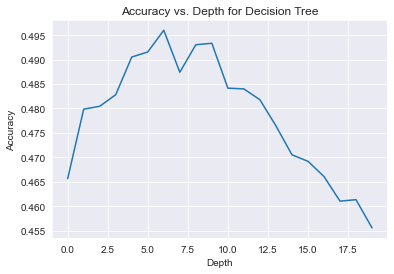

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
plt.plot(depth, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title("Accuracy vs. Depth for Decision Tree")
plt.show()

In [25]:
# so we can see that a depth of 6 is probably the best
# lets take a closer look at this decision tree
dt = DecisionTreeClassifier(max_depth =6)
dt.fit(train_features, train_labels)
results = dt.predict(test_features)
actual = np.array(test_labels)

In [26]:
cm = sk.metrics.confusion_matrix(results, actual)

In [27]:
cm

array([[ 236,   80,  176,   95],
       [ 157, 2750,  646, 1453],
       [ 250,  226,  283,  260],
       [  10,   52,   28,   50]])

In [28]:
print(sk.metrics.classification_report(results, actual))

              precision    recall  f1-score   support

           0       0.36      0.40      0.38       587
           1       0.88      0.55      0.68      5006
           2       0.25      0.28      0.26      1019
           3       0.03      0.36      0.05       140

    accuracy                           0.49      6752
   macro avg       0.38      0.40      0.34      6752
weighted avg       0.73      0.49      0.58      6752



In [29]:
# now move on to random forests

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, random_state=2)

In [34]:
rf.fit(train_features, train_labels)

RandomForestClassifier(max_depth=5, random_state=2)

In [35]:
results = rf.predict(test_features)

In [36]:
actual = np.array(test_labels)

In [37]:
total_count = 0
correct = 0
for j in range(len(actual)):
    total_count += 1
    if actual[j] == results[j]:
        correct += 1
accuracy = correct / total_count

In [38]:
print("Random Forest Accuracy: ", accuracy)

Random Forest Accuracy:  0.4693424170616114


In [41]:
for i in range(15,20):
    for k in range(1,100,10):
        rf = RandomForestClassifier(max_depth=i+1, n_estimators = k,random_state=0)
        rf.fit(train_features, train_labels)
        results = rf.predict(test_features)
        actual = np.array(test_labels)
        total_count = 0
        correct = 0
        for j in range(len(actual)):
            total_count += 1
            if actual[j] == results[j]:
                correct += 1
        accuracy = correct / total_count
        print("Random Forest Accuracy for Max Depth of {}: , estimators = {}".format(i+1,k), accuracy)

Random Forest Accuracy for Max Depth of 16: , estimators = 1 0.46238151658767773
Random Forest Accuracy for Max Depth of 16: , estimators = 11 0.49229857819905215
Random Forest Accuracy for Max Depth of 16: , estimators = 21 0.5016291469194313
Random Forest Accuracy for Max Depth of 16: , estimators = 31 0.5048874407582938
Random Forest Accuracy for Max Depth of 16: , estimators = 41 0.5059241706161137
Random Forest Accuracy for Max Depth of 16: , estimators = 51 0.5099229857819905
Random Forest Accuracy for Max Depth of 16: , estimators = 61 0.5103672985781991
Random Forest Accuracy for Max Depth of 16: , estimators = 71 0.5099229857819905
Random Forest Accuracy for Max Depth of 16: , estimators = 81 0.5103672985781991
Random Forest Accuracy for Max Depth of 16: , estimators = 91 0.5111078199052133
Random Forest Accuracy for Max Depth of 17: , estimators = 1 0.4574940758293839
Random Forest Accuracy for Max Depth of 17: , estimators = 11 0.48696682464454977
Random Forest Accuracy for 

In [42]:
# so lets take max depth of 16, 100 estimators

rf = RandomForestClassifier(max_depth=16, n_estimators = 100,random_state=0)
rf.fit(train_features, train_labels)
results = rf.predict(test_features)
actual = np.array(test_labels)

In [43]:
print(sk.metrics.classification_report(results, actual))

              precision    recall  f1-score   support

           0       0.38      0.53      0.44       464
           1       0.88      0.56      0.69      4874
           2       0.21      0.32      0.25       755
           3       0.12      0.34      0.18       659

    accuracy                           0.51      6752
   macro avg       0.40      0.44      0.39      6752
weighted avg       0.70      0.51      0.57      6752



In [49]:
# lets print out the decision tree we had
from sklearn import tree
from matplotlib import pyplot as plt

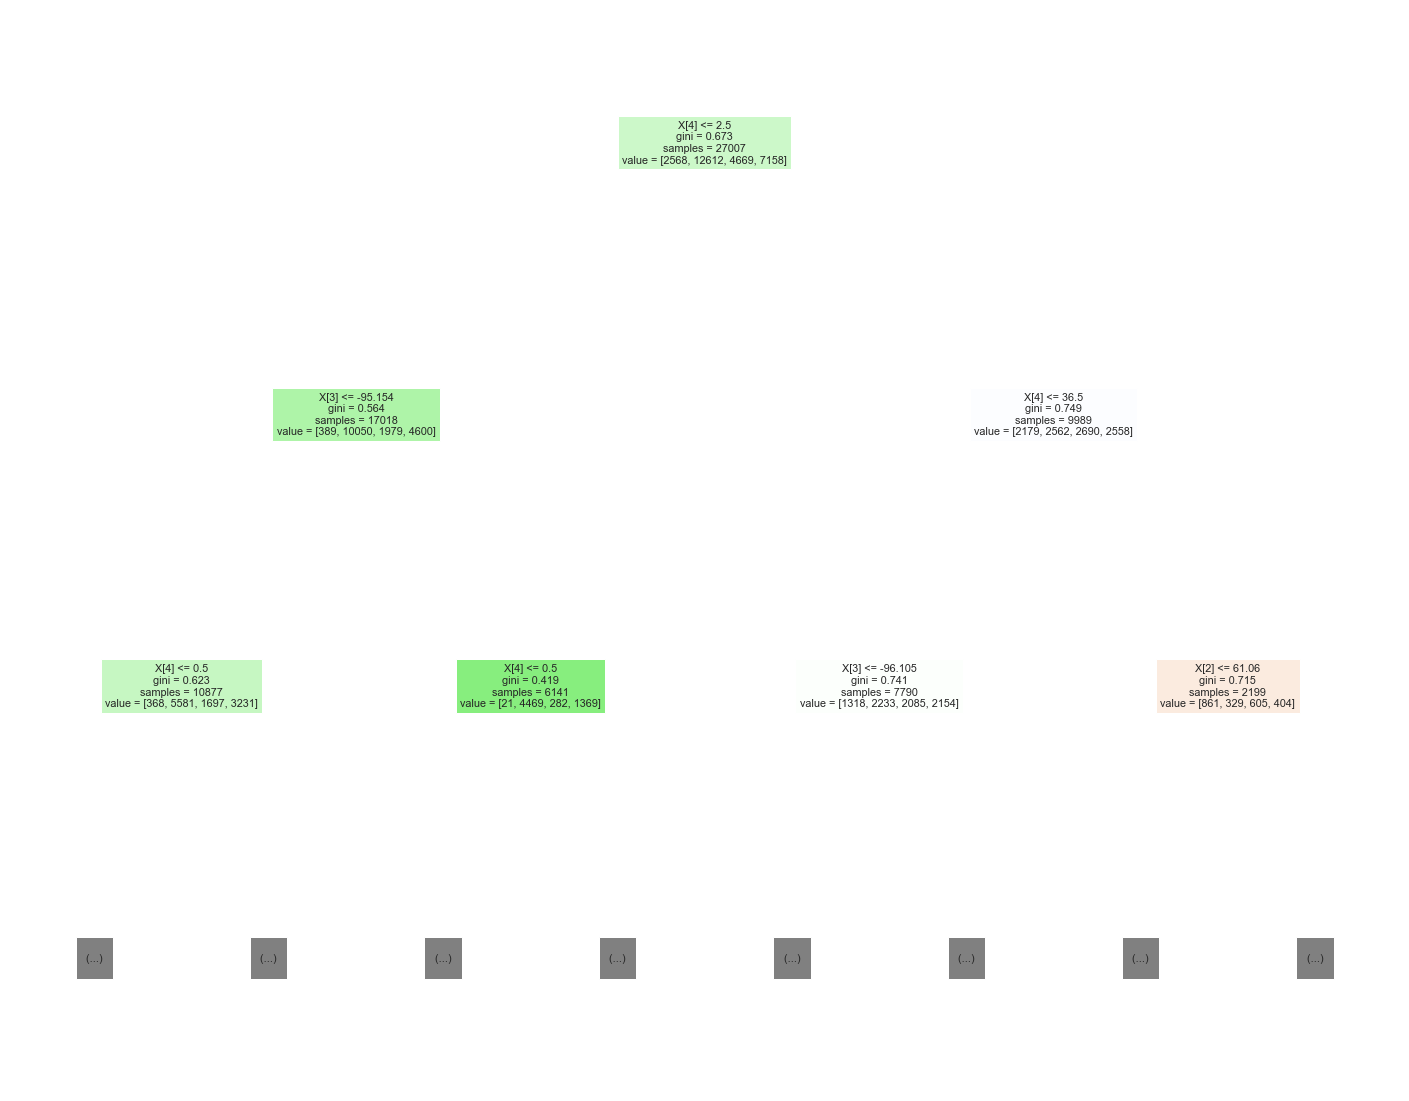

In [57]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   max_depth = 2,
                   filled=True)


In [52]:
fig.savefig("decistion_tree.png")


In [53]:
text = tree.export_text(dt)

In [55]:
print(text)

|--- feature_4 <= 2.50
|   |--- feature_3 <= -95.15
|   |   |--- feature_4 <= 0.50
|   |   |   |--- feature_0 <= 2012.50
|   |   |   |   |--- feature_33 <= 0.50
|   |   |   |   |   |--- feature_60 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_60 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_33 >  0.50
|   |   |   |   |   |--- feature_16 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_16 >  0.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |--- feature_0 >  2012.50
|   |   |   |   |--- feature_2 <= 34.31
|   |   |   |   |   |--- feature_2 <= 30.96
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_2 >  30.96
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  34.31
|   |   |   |   |   |--- feature_3 <= -95.17
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_3 >  -95.17
|   |   |   |   |   |   |--- class: 3
|   |   |--- feature_4 

In [58]:
# lets experience with a neural network i guess..

In [59]:
from sklearn.neural_network import MLPClassifier

In [68]:
nn = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100))

In [69]:
nn.fit(train_features, train_labels)

MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100))

In [70]:
results = nn.predict(test_features)

In [71]:
print(sk.metrics.classification_report(results, actual))

              precision    recall  f1-score   support

           0       0.34      0.36      0.35       617
           1       0.87      0.56      0.68      4800
           2       0.33      0.28      0.31      1335
           3       0.00      0.00      0.00         0

    accuracy                           0.49      6752
   macro avg       0.38      0.30      0.33      6752
weighted avg       0.71      0.49      0.58      6752



/Users/lukenijhawan/opt/anaconda3/envs/isye/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
